# "Knox" calculation

J. Ruhl, March 2022.

Here we use the "Knox" equation (equation 4 of https://arxiv.org/pdf/astro-ph/9504054.pdf ;  be sure to read the acknowledgements section, of which I am most proud!) to estimate errors on measurements of $D_\ell$ by an experiment with known beamwidth, sky coverage fraction, sensitivity, and observing time.

(We'll use formulas from Seljak and Zaldarriaga 1996 (https://arxiv.org/pdf/astro-ph/9609170.pdf, equation 43), which give the covariances for TE as well as the others.)

The Knox formula for the errors on the temperature anisotropy power spectrum is

$$ \Delta C_\ell^{TT} = 
\sqrt{\frac{2}{(2\ell + 1)f_{sky}}} \left[ C_\ell^{TT} + w^{-1} W_\ell^{-1} \right] $$

where $w$ is the instrument noise weight per unit solid angle, and $W$ is a "window function" that encodes
the effect of the beam and other filtering.  The instrument noise term is often replaced by $N_\ell = w^{-1} W_\ell^{-1}$;  note that if the window function $W$ is independent of $\ell$ (which is never strictly true, but is good to think about) $N_\ell$ will be independent of $\ell$, ie "flat", or "white".


We often want to work with
$$ D_\ell = \frac{\ell (\ell+1)}{2 \pi} , $$ 

so that

$$ \Delta D_\ell^{TT} = 
\sqrt{\frac{2}{(2\ell + 1)f_{sky}}} \left[ D_\ell^{TT} + \frac{\ell (\ell+1)}{2 \pi} w^{-1} W_\ell^{-1} \right] $$

which is often written as

$$\Delta D_\ell^{TT} = 
\sqrt{\frac{2}{(2\ell + 1)f_{sky}}} \left[ D_\ell^{TT} + \frac{\ell (\ell+1)}{2 \pi} N_\ell \right] $$

In this notebook we'll calculate $N_\ell$ for an experiment, 
then use it to calculate the errors on a CMB power spectrum binned in $\ell$, where as you might expect the errors on adjacent $\ell$'s add in quadrature in that binning.

Before we start, we note that there are two terms in the square brackets in the equation for $\Delta D_\ell$ above.  The first is just the magnitude of the $D_\ell$'s themselves.  This term comes from the fact that we have only $2 \ell + 1$ $a_{\ell m}$'s making up the sky signal at that $\ell$, so the observed value of $D_\ell$ will 
vary from one observer (or realization of the universe) to the next.  This term is known as the "cosmic variance", at least when $f_{sky} = 1$.   If we use a smaller $f_{sky}$ it is usually called the "sample variance".

The second term in the square brackets is due to the instrument noise;  we'll talk more 
about it below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10,6]

Read in a set of CMB power spectra.  These are from camb, so they are $D_\ell$'s.

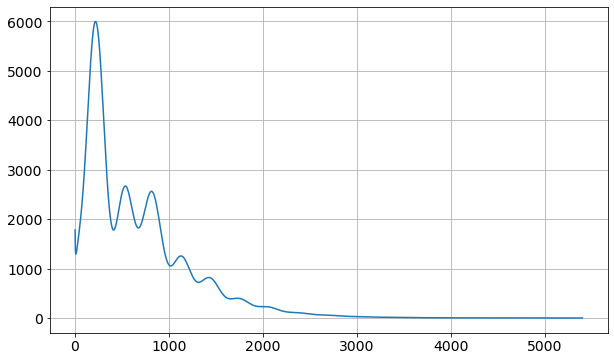

In [2]:
D_ell_file = 'CMB_fiducial_totalCls.dat' 
D_ells = np.loadtxt(D_ell_file)  # T_0^2*ell*(ell+1) * C_ell / (2*pi)  (uK^2)
ell = D_ells[:,0]
Dl_TT=D_ells[:,1]
Dl_EE=D_ells[:,2]
Dl_BB=D_ells[:,3]
dl_TE=D_ells[:,4]
ell_factor = ell*(ell+1)/(2*np.pi)  # useful in converting between C_ell and D_ell
plt.plot(ell,Dl_TT)
plt.grid()


Define the instrument and calculate $N_\ell$.

T map depth = 48.52 uK_cmb-arcmin
P map depth = 68.62 uK_cmb-arcmin


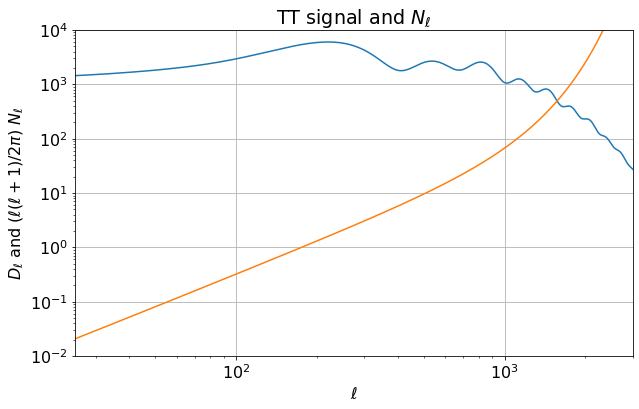

In [3]:
# Define a "white noise only" instrument and its observations.
planck150={'title': 'Planck - approx 150',
        'net': 100,  # uKrtsec_cmb, per wafer
        'years': 2,  
        'fwhm': 7,  #arcmin   
        'ndet': 10, # detectors
        'fsky': 1.0,  #sky area coverage
        'deltaell': 50,
        'topbin': 3000,
        'lowestell': 2,
        }
expt = planck150

# Find the weights per unit solid angle
seconds = expt['years']*365*24*60*60.
sig2_T=(expt['net']/np.sqrt(expt['ndet']*seconds))**2
sig2_P= 2*sig2_T  #in uK^2
#
w_T=(1/sig2_T)/(expt['fsky']*4*np.pi)  #1/(uK^2 rad^2);
w_P=(1/sig2_P)/(expt['fsky']*4*np.pi)
inv_w_T=1/w_T  # (uK-radian)^2
inv_w_P=1/w_P
#
# Depth in uK-arcmin, for comparison purposes
sky_sqdeg = 41253 #square degrees on sphere
sky_sqarcmin = sky_sqdeg*60*60.  # square arcminutes on the sphere
sqarcmin_per_sr = sky_sqarcmin/(4*np.pi)
mapdepth_T = np.sqrt(inv_w_T*sqarcmin_per_sr)
mapdepth_P = np.sqrt(inv_w_P*sqarcmin_per_sr)
print('T map depth = {0:.2f} uK_cmb-arcmin'.format(mapdepth_T))
print('P map depth = {0:.2f} uK_cmb-arcmin'.format(mapdepth_P))

# Find W_l and W_l^-1 from the beam
#   Have to convert fwhm->sigma, and arcmin -> radians
sigma_beam=(expt['fwhm']/ (np.sqrt(8*np.log(2))))*(np.pi/180/60) 

W = np.exp(-ell**2 * sigma_beam**2)
inv_W = (1/W)

N_l_T = inv_w_T * inv_W
N_l_P = inv_w_P * inv_W

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
# Plot D_ell on the y axis
plt.loglog(ell,Dl_TT)
plt.loglog(ell,ell_factor*N_l_T)
plt.xlim(25,3000)
plt.ylim(0.01,1e4)
plt.xlabel('$\ell$')
plt.ylabel('$D_\ell$ and $(\ell (\ell + 1) / 2 \pi) \  N_\ell$')
plt.title('TT signal and $N_\ell$')
plt.grid()

Here we see the usual TT power spectrum, and that in D_ell space the "white noise" N_ell curve rises approximately as $\ell^2$ towards high ell.  (We made this plot log-log so that a power law would appear as a straight line).  The point where the two curves cross marks the point at which the experiment goes from being "cosmic variance limited" (on the left) to "instrument noise limited" (on the right).

Let's look at these exact same curves in "C_ell" space.

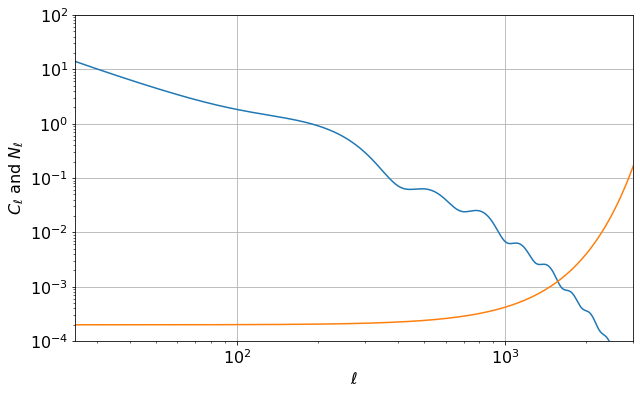

In [4]:
# Plot C_ell on the y axis
plt.loglog(ell,Dl_TT/ell_factor)
plt.loglog(ell,N_l_T)
plt.xlim(25,3000)
plt.ylim(1e-4, 100)
#plt.ylim(1,1e4)
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$ and $ N_\ell$')
plt.grid()

We're not used to seeing the C_ell TT signal curve, but that's what it looks like.  Note that the N_ell curve is flat at low ell;  the rise to high ell is due to the beam factor.  If you go back to the experiment definition and reduce the beam fwhm to 1 arcminute, say, and rerun the cells to this plot, you'll see a much flatter (to higher ell) N_ell curve.  This is a good thing to remember;  white instrument noise N_ell is "white" (ie flat) in C_ell space, but goes as roughly $\ell^2$ in D_ell space.

# $N_\ell$ vs errors on $D_\ell$

Note that $N_\ell$ is calculated from the experiment's weight in units of uK-arcmin, ie the map-depth.  Two experiments that have the same map depth, but different sky coverage areas, will have the same $N_\ell$.  Clearly and experiment with larger sky area (and same map-depth) is actually more powerful!

That added power is included when we calculate the $\Delta D_\ell$'s, using 

$$\Delta D_\ell^{TT} = 
\sqrt{\frac{2}{(2\ell + 1)f_{sky}}} \left[ D_\ell^{TT} + \frac{\ell (\ell+1)}{2 \pi} N_\ell \right] $$

Looking again at this equation, we see $f_{sky}$ in the prefactor, and that $N_\ell$ is the instrument noise on par with the "cosmic variance" term;  that is, instrument noise dominates when $N_\ell > C_\ell$.

With this in mind, the plot above shows a region in the middle where $N_\ell$ is lower than the signal power spectrum;  we should not interpret this as "noise is less than signal" here;  the true meaning is that the "contribution of instrument noise is less than cosmic (or sample) variance, here."

# Plot errors for a full-sky observation
Now let's plot not only $N_\ell$, but also the full errors $\Delta D_\ell$ as well.

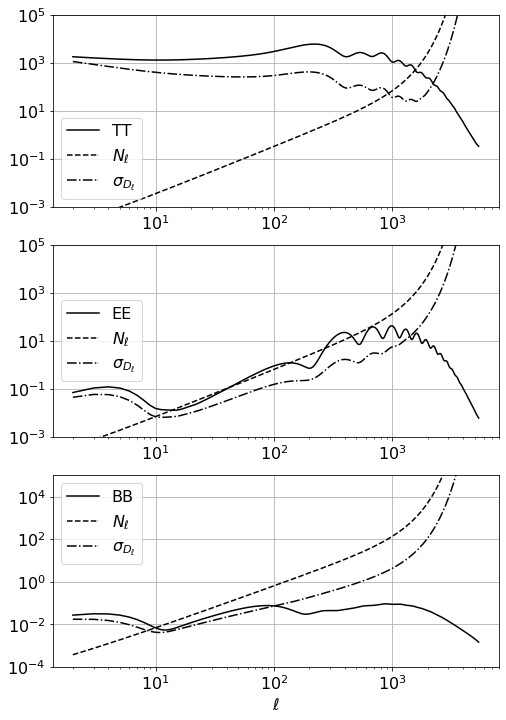

In [5]:

A=np.sqrt(2.0 / (expt['fsky'] * (2.0 * ell + 1)))
sigma_DTT= A*(Dl_TT + ell_factor*N_l_T)
sigma_DEE= A*(Dl_EE + ell_factor*N_l_P)
sigma_DBB= A*(Dl_BB + ell_factor*N_l_P)

# The TE one is different.
#cov_DTE = A*(Dl_TE + np.sqrt((Dl_TT + ell_factor*N_l_T)*(Dl_EE + ell_factor*N_l_P)) )

# Do separate plots for each power spectrum, TT, EE, BB. (Ignore TE again)
plt.rcParams['figure.figsize'] = [8,12]
plt.subplot(3,1,1)
plt.loglog(ell,Dl_TT,'k',label = 'TT')
plt.loglog(ell,ell_factor*N_l_T,'k--', label = '$N_\ell$')
plt.loglog(ell, sigma_DTT,'k-.', label = '$\sigma_{D_\ell}$')
plt.ylim(0.001,1e5)
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.loglog(ell,Dl_EE,'k', label = 'EE')
plt.loglog(ell,ell_factor*N_l_P,'k--', label = '$N_\ell$')
plt.loglog(ell,sigma_DEE,'k-.', label = '$\sigma_{D_\ell}$')
plt.ylim(0.001,1e5)
plt.legend(loc='center left')
plt.grid()

plt.subplot(3,1,3)
plt.loglog(ell,Dl_BB,'k',label='BB')
plt.loglog(ell,ell_factor*N_l_P,'k--', label='$N_\ell$')
plt.loglog(ell,sigma_DBB,'k-.',label='$\sigma_{D_\ell}$')
plt.ylim(0.0001,1e5)
plt.xlabel('$\ell$')
plt.legend()
plt.grid()

#plt.xlim(1,5000)


It is instructive to look over the plots above and think about where this particular measurement has errors on $D_\ell$ that are dominated by instrument noise vs cosmic variance.  

# Small sky experiment  (White noise) with binned values in $\ell$
Let's now look at a different instrument that measures a small fraction of the sky.  This obviously comes in to 
our formulas via the $f_{sky}$ factors above, but we also need to recognize that we need to "bin" in ell-space
if we're not observing the full sky.  The different $Y_{\ell,m}$'s are not orthogonal with partial-sky coverage, so our signal estimates and errors will also be correlated over some range of $\ell$.  We can guess that correlations in $\ell$ are probably strong over a width $\Delta \ell$ that is related to $f_{sky}$.  Imagine
a square, "flat sky" patch with a side length $\theta$ degrees.  The longest full oscillation that will fit in that patch has a wavelength of $\theta$, corresponding to $\ell \sim 360/\theta$.  

On the other hand, this patch has $f_{sky} = \theta^2 / 41253$, so we can use bins of width

$$\Delta \ell \sim \frac{360}{\theta} \sim \frac{360}{\sqrt{41253 f_{sky}}} \ .$$

We're going to average the $D_\ell$'s in an $\ell$-bin, so the error will go down as the inverse square root of the number of ell's we bin.  The Knox formula becomes

$$\Delta D_\ell^{TT} = 
\sqrt{\frac{2}{(2\ell + 1)f_{sky} \Delta \ell}} \left[ D_\ell^{TT} + \frac{\ell (\ell+1)}{2 \pi} N_\ell \right] $$


Let's first define a new experiment, define a "binning" function to do all that work for us, and then make some "binned" power spectrum plots.

In [6]:
# Quick calc of the formulas above, to inform our small-sky expt definition in the next cell.
fsky = 0.03
deltaell = 360/(np.sqrt(fsky*41253))
print(deltaell)

10.233262273206732


In [7]:
# Define a "white noise only" instrument and its observations.
smallsky={'title': 'small sky expt',
        'net': 400,  # uKrtsec_cmb, per wafer
        'years': 5*0.25,  
        'fwhm': 2,  #arcmin   
        'ndet': 1e4, # detectors
        'fsky': 0.03,  #sky area coverage
        'deltaell': 20,
        'highestell': 3000,
        'lowestell': 20,
        }
expt = smallsky
ellbin_loweredges = np.arange(expt['lowestell'],expt['highestell'],expt['deltaell'])
logellbins_loweredges = np.logspace(np.log10(expt['lowestell']),np.log10(expt['highestell']),40)
print(logellbins_loweredges)

def binit(ellbin_loweredges,ell_full,X_full):
    X_binned = np.array([])
    nbins = len(ellbin_loweredges)
    for ii in np.arange(nbins-1):
        booarr = (ell_full>=ellbin_loweredges[ii]) & (ell_full<ellbin_loweredges[ii+1])
        Xvals = X_full[booarr]
        val = np.mean(Xvals)
        X_binned = np.append(X_binned,np.mean(Xvals))
    return(X_binned)


[  20.           22.74192419   25.85975579   29.40503028   33.43634847
   38.0203451    43.23279029   49.15984196   55.89946995   63.56307538
   72.27733208   82.18628033   93.45370782  106.26585692  120.83450309
  137.40045542  156.23753703  177.65711112  202.01322762  229.70847537
  261.2006366   297.01025377  337.72923371  384.03063144  436.6797753
  496.5469172   564.62161733  642.0291008   730.04885682  830.13578775
  943.94425752 1073.35543709 1220.50839883 1387.83547382 1578.10245652
 1794.45432131 2040.46720666 2320.20752605 2638.29918283 3000.        ]


In [8]:
# Let's use the log spacing for bins because it's more appropriate in this very-wide ell-space spectrum...
ellbin_loweredges = logellbins_loweredges

## same code as before, to get to N_ell and then delta C_ell etc.
seconds = expt['years']*365*24*60*60.
sig2_T=(expt['net']/np.sqrt(expt['ndet']*seconds))**2
sig2_P= 2*sig2_T  #in uK^2
#
w_T=(1/sig2_T)/(expt['fsky']*4*np.pi)  #weight per unit solid angle, 1/(uK^2 rad^2);
w_P=(1/sig2_P)/(expt['fsky']*4*np.pi)
inv_w_T=1/w_T  # (uK-radian)^2
inv_w_P=1/w_P
#
# Depth in uK-arcmin, for comparison purposes
sky_sqdeg = 41253 #square degrees on sphere
sky_sqarcmin = sky_sqdeg*60*60.  # square arcminutes on the sphere
sqarcmin_per_sr = sky_sqarcmin/(4*np.pi)
mapdepth_T = np.sqrt(inv_w_T*sqarcmin_per_sr)
mapdepth_P = np.sqrt(inv_w_P*sqarcmin_per_sr)
print('T map depth = {0:.2f} uK_cmb-arcmin'.format(mapdepth_T))
print('P map depth = {0:.2f} uK_cmb-arcmin'.format(mapdepth_P))

# Find W_l and W_l^-1 from the beam
#   Have to convert fwhm->sigma, and arcmin -> radians
sigma_beam=(expt['fwhm']/ (np.sqrt(8*np.log(2))))*(np.pi/180/60) 

W = np.exp(-ell**2 * sigma_beam**2)
inv_W = (1/W)

N_l_T = inv_w_T * inv_W
N_l_P = inv_w_P * inv_W

A=np.sqrt(2.0 / (expt['fsky'] * (2.0 * ell + 1)))
sigma_DTT= A*(Dl_TT + ell_factor*N_l_T)
sigma_DEE= A*(Dl_EE + ell_factor*N_l_P)
sigma_DBB= A*(Dl_BB + ell_factor*N_l_P)

# Bin all of these
ell_binned = binit(ellbin_loweredges,ell,ell)
DTT_binned = binit(ellbin_loweredges,ell,Dl_TT)
DEE_binned = binit(ellbin_loweredges,ell,Dl_EE)
DBB_binned = binit(ellbin_loweredges,ell,Dl_BB)
sigma_DTT_binned = binit(ellbin_loweredges,ell,sigma_DTT)
sigma_DEE_binned = binit(ellbin_loweredges,ell,sigma_DEE)
sigma_DBB_binned = binit(ellbin_loweredges,ell,sigma_DBB)

T map depth = 1.34 uK_cmb-arcmin
P map depth = 1.90 uK_cmb-arcmin


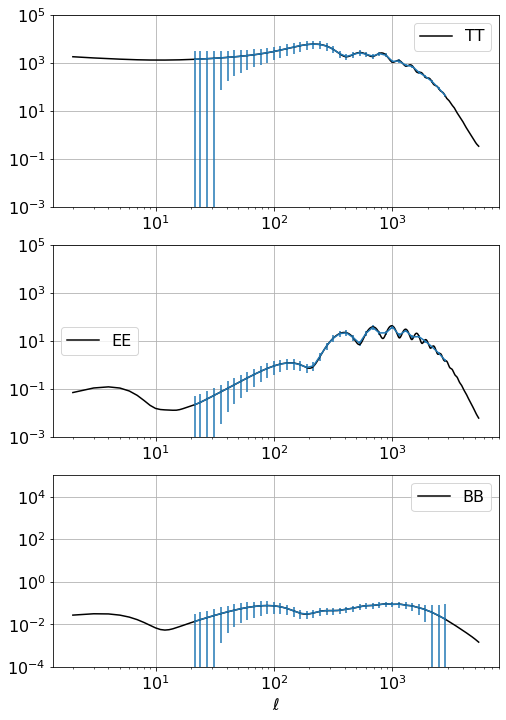

In [9]:
# And same code to plot
# Do separate plots for each power spectrum, TT, EE, BB. (Ignore TE again)
plt.rcParams['figure.figsize'] = [8,12]
plt.subplot(3,1,1)
plt.loglog(ell,Dl_TT,'k',label = 'TT')
plt.errorbar(ell_binned,DTT_binned,sigma_DTT_binned)
plt.ylim(0.001,1e5)
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.loglog(ell,Dl_EE,'k', label = 'EE')
plt.errorbar(ell_binned,DEE_binned,sigma_DEE_binned)
plt.ylim(0.001,1e5)
plt.legend(loc='center left')
plt.grid()

plt.subplot(3,1,3)
plt.loglog(ell,Dl_BB,'k',label='BB')
plt.errorbar(ell_binned,DBB_binned,sigma_DBB_binned)
plt.ylim(0.0001,1e5)
plt.xlabel('$\ell$')
plt.legend()
plt.grid()

It looks like this experiment, which is not far from SPT-3g in its horsepower, has a shot at detecting whatever BB "primordial bump" power is in that lowest plot.  This is because we haven't taken into account the fact that the "white instrument noise" assumption usually falls apart at lower ells due to atmospheric noise, and instrument 1/f noise.

We can capture those by including an "1/ell and atmospheric noise" factor to our $N_\ell$'s.  Let's use CMB-S4's factors for the SPLAT as an example, here.

The parameterization of $N_\ell$ used by CMB-S4 is

$$ N_\ell = \Delta^2 B_\ell p_\ell $$

where $\Delta^2$ is the white noise map depth and is equivalent to the instrument weight $w$ above, $B_\ell$ is the beam factor we used for $W_\ell$ above, and I'm introducing the notation 

$$ p_\ell =  1 + \left( \frac{\ell_{knee}}{\ell} \right)^\alpha $$

The atmosphere has more TT noise than EE or BB (ie its fluctuations are not very polarized), so we use
different values of $\ell_{knee}$ and $\alpha$ for the TT and EE/BB spectra, as well as for different frequency bands.  At 150 GHz on the SPLAT for example, we're currently using

Temperature:  $\alpha = 4.1$, $\ell_{knee} = 1900 \ ,$

Polarization: $\alpha = 2.2$, $\ell_{knee} = 200 \ .$

Let's plot the N_ell's on top of eachother, in "C_ell" space where the N_ell's should be flat at low ell.



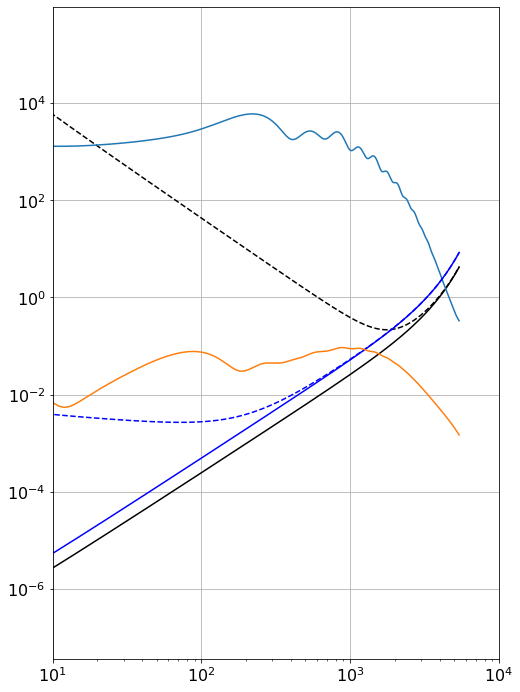

In [10]:
alphaT = 4.1
ell_kneeT = 1900
alphaP = 2.2
ell_kneeP = 200

p_l_T = 1 + (ell_kneeT/ell)**alphaT
p_l_P = 1 + (ell_kneeP/ell)**alphaP

plt.loglog(ell,N_l_T*ell_factor,'k')
plt.loglog(ell,N_l_T*p_l_T*ell_factor,'--k')
plt.loglog(ell,Dl_TT)

plt.loglog(ell,N_l_P*ell_factor,'b')
plt.loglog(ell,N_l_P*p_l_P*ell_factor,'--b')
plt.loglog(ell,Dl_BB)


#plt.ylim(1e-8,100)
plt.xlim(10,10000)
plt.grid()

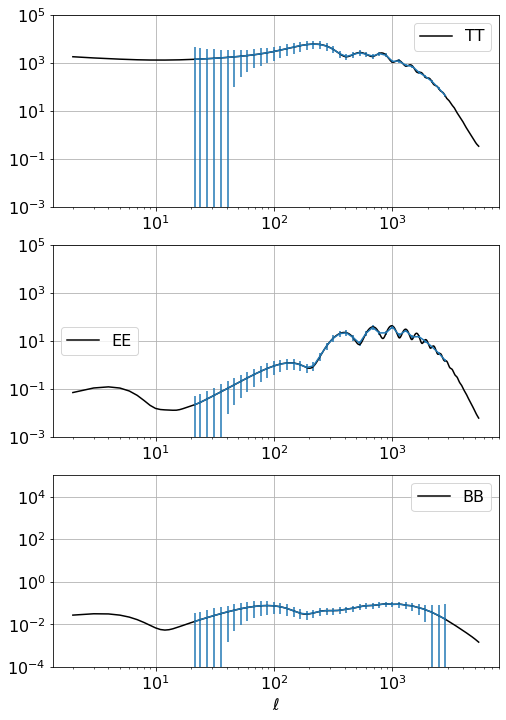

In [11]:
A=np.sqrt(2.0 / (expt['fsky'] * (2.0 * ell + 1)))
sigma_DTT= A*(Dl_TT + ell_factor*N_l_T*p_l_T)
sigma_DEE= A*(Dl_EE + ell_factor*N_l_P*p_l_P)
sigma_DBB= A*(Dl_BB + ell_factor*N_l_P*p_l_P)

# Bin all of these
ell_binned = binit(ellbin_loweredges,ell,ell)
DTT_binned = binit(ellbin_loweredges,ell,Dl_TT)
DEE_binned = binit(ellbin_loweredges,ell,Dl_EE)
DBB_binned = binit(ellbin_loweredges,ell,Dl_BB)
sigma_DTT_binned = binit(ellbin_loweredges,ell,sigma_DTT)
sigma_DEE_binned = binit(ellbin_loweredges,ell,sigma_DEE)
sigma_DBB_binned = binit(ellbin_loweredges,ell,sigma_DBB)

# And same code to plot
# Do separate plots for each power spectrum, TT, EE, BB. (Ignore TE again)
plt.rcParams['figure.figsize'] = [8,12]
plt.subplot(3,1,1)
plt.loglog(ell,Dl_TT,'k',label = 'TT')
plt.errorbar(ell_binned,DTT_binned,sigma_DTT_binned)
plt.ylim(0.001,1e5)
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.loglog(ell,Dl_EE,'k', label = 'EE')
plt.errorbar(ell_binned,DEE_binned,sigma_DEE_binned)
plt.ylim(0.001,1e5)
plt.legend(loc='center left')
plt.grid()

plt.subplot(3,1,3)
plt.loglog(ell,Dl_BB,'k',label='BB')
plt.errorbar(ell_binned,DBB_binned,sigma_DBB_binned)
plt.ylim(0.0001,1e5)
plt.xlabel('$\ell$')
plt.legend()
plt.grid()

# Zero signal case, errors vs sky fraction

Going back to the original equation for errors on $D_{\ell}$, 
$$ \Delta D_\ell^{TT} = 
\sqrt{\frac{2}{(2\ell + 1)f_{sky}}} \left[ D_\ell^{TT} + \frac{\ell (\ell+1)}{2 \pi} w^{-1} W_\ell^{-1} \right] $$
let's look at how the errors scale with $f_{sky}$, in the limit where the signal is zero.

Dispensing with the signal term, we have
$$ (\Delta D_\ell)^2 \propto \frac{1}{f_{sky} w^2}$$
where $w$ is the weight per unit solid angle.  If we have an experiment with total weight $w_{tot}$, then 
$$ (\Delta D_\ell)^2 \propto \frac{1}{f_{sky} (w_{tot}/f_{sky})^2}$$
$$ (\Delta D_\ell)^2 \propto f_{sky} $$
$$ \Delta D_\ell \propto \sqrt{f_{sky}} $$

Let's demonstrate that using the actual calculation, with the formulas above.

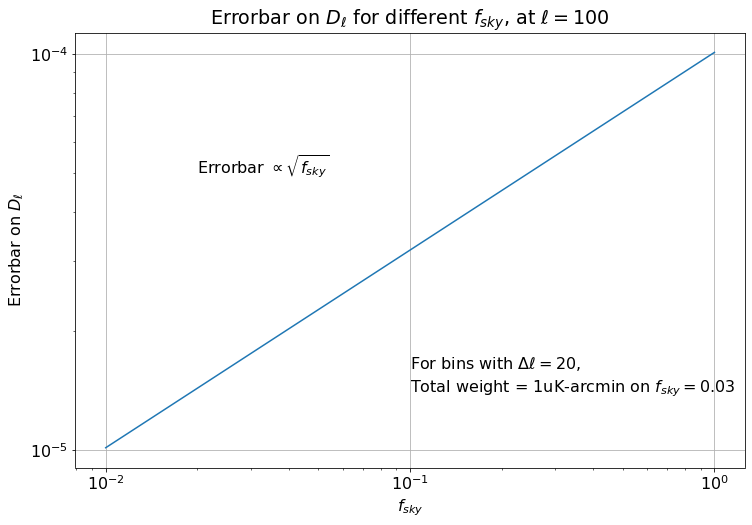

In [64]:
# Define experiment default configuration
uKarcmin_0 = 1  # map depth
fsky_0 = 0.03
sqarcmin_0 = fsky_0*41253*(60**2)
weight_0 = sqarcmin_0*(1/uKarcmin_0**2) 
#
fsky_vec = np.logspace(-2,0,100)
solid_angle = fsky_vec*4*np.pi
w = weight_0/solid_angle
#
delta_ell = 20
ell = 100
sigma_Dl = np.sqrt(2/((2*ell + 1)*fsky_vec*delta_ell)) * (ell*(ell+1)/(2*np.pi))*(1/w)
#
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12,8]
plt.loglog(fsky_vec,sigma_Dl)
plt.title('Errorbar on $D_{\ell}$ for different $f_{sky}$, at $\ell = 100$')
plt.ylabel('Errorbar on $D_{\ell}$')
plt.xlabel('$f_{sky}$')
plt.text(0.1,1.6e-5,'For bins with $\Delta \ell = 20$,')
plt.text(0.1,1.4e-5,'Total weight = 1uK-arcmin on $f_{sky}=0.03$')
plt.text(0.02,5e-5,'Errorbar $\propto \sqrt{f_{sky}}$ ')

plt.grid()


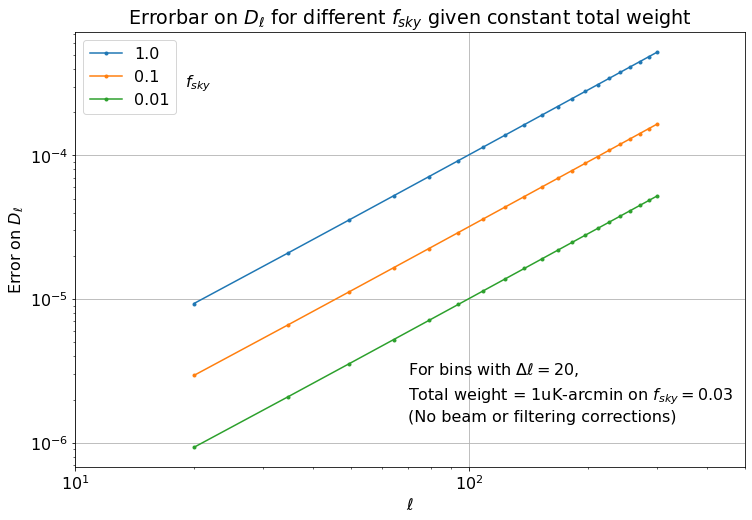

In [127]:
# Define experiment default configuration
uKarcmin_0 = 1  # map depth
fsky_0 = 0.03
sqarcmin_0 = fsky_0*41253*(60**2)
weight_0 = sqarcmin_0*(1/uKarcmin_0**2) 
#
delta_ell = 20
#
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12,8]
ell = np.linspace(20,300,delta_ell)
for fsky in [1.0, 0.1, 0.01]:
    solid_angle = fsky*4*np.pi
    w = weight_0/solid_angle
    sigma_Dl = np.sqrt(2/((2*ell + 1)*fsky*delta_ell)) * (ell*(ell+1))/(2*np.pi) * (1/w)
    plt.loglog(ell,sigma_Dl,'.-',label = fsky)
plt.legend()
plt.title('Errorbar on $D_{\ell}$ for different $f_{sky}$ given constant total weight')
plt.ylabel('Error on $D_{\ell}$')
plt.xlabel('$\ell$')
plt.xlim(10,500)
plt.text(70,3e-6,'For bins with $\Delta \ell = 20$,')
plt.text(70,2e-6,'Total weight = 1uK-arcmin on $f_{sky}=0.03$')
plt.text(70,1.4e-6,'(No beam or filtering corrections)')
plt.text(19,3e-4,'$f_{sky}$')
plt.grid()


$$ \Delta D_\ell = 
\sqrt{\frac{2}{(2\ell + 1)f_{sky}}} \left[ D_\ell + \frac{\ell (\ell+1)}{2 \pi} w^{-1} W_\ell^{-1} \right] $$

$$ \Delta D_{\ell,binned} = 
\sqrt{\frac{2}{(2\ell + 1) \ \Delta\ell \ f_{sky}}} \left[ D_\ell + \frac{\ell (\ell+1)}{2 \pi} w^{-1} W_\ell^{-1} \right] $$

$$ \Delta D_\ell \ \propto \ 
\sqrt{\frac{2}{(2\ell + 1)f_{sky}}} \left[ \frac{\ell (\ell+1)}{2 \pi} \frac{4\pi f_{sky}}{w_{tot}}  \right] $$

$$ \Delta D_\ell \ \propto \ \sqrt{ f_{sky} } $$


Text(0.5, 0.98, 'Signal estimate, equal total weights')

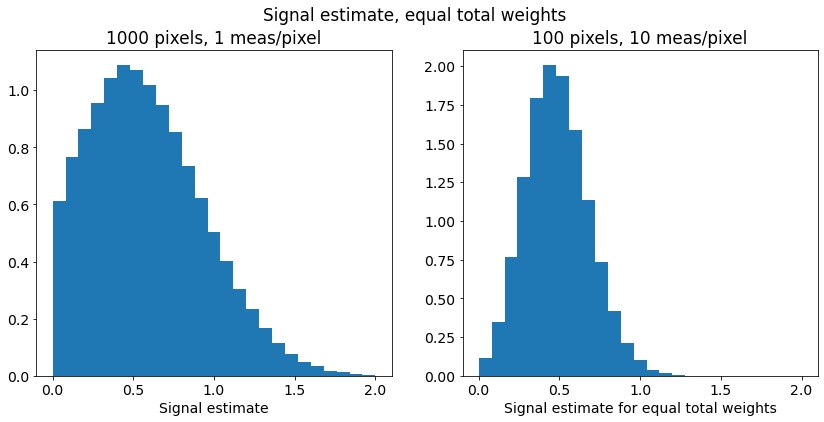

In [128]:
sigamp = np.sqrt(0.5)
noiseamp = 3

maxpix = 1000
niter = 100000

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [14,6]
fig,axs = plt.subplots(1,2)

npix = 1000
meas_per_pix = maxpix/npix
noiseamp_per_pix = noiseamp/np.sqrt(meas_per_pix)
sigest_vec = np.array([])
for ii in np.arange(niter):
    signal = sigamp*np.random.randn(npix)
    noise = noiseamp_per_pix*np.random.randn(npix)
    tot = signal + noise
    ms_tot = np.var(tot)
    ms_sig_est = ms_tot - noiseamp_per_pix**2
    sigest_vec = np.append(sigest_vec,ms_sig_est)
axs[0].hist(sigest_vec,range=(0,2.0),bins=25,density=True)
axs[0].set_xlabel('Signal estimate')
axs[0].set_title('1000 pixels, 1 meas/pixel')


npix = 100
meas_per_pix = maxpix/npix
noiseamp_per_pix = noiseamp/np.sqrt(meas_per_pix)
sigest_vec = np.array([])
for ii in np.arange(niter):
    signal = sigamp*np.random.randn(npix)
    noise = noiseamp_per_pix*np.random.randn(npix)
    tot = signal + noise
    ms_tot = np.var(tot)
    ms_sig_est = ms_tot - noiseamp_per_pix**2
    sigest_vec = np.append(sigest_vec,ms_sig_est)
axs[1].hist(sigest_vec,range=(0,2.0),bins=25,density=True)
axs[1].set_xlabel('Signal estimate for equal total weights')
axs[1].set_title('100 pixels, 10 meas/pixel')

fig.suptitle('Signal estimate, equal total weights')



# Old code below here

In [ ]:
   
 
    wB_T=inv_w_T * numpy.exp((l_b*l_b) * sigb2)    #weight times beam factor
    wB_P=inv_w_P * numpy.exp((l_b*l_b) * sigb2)

In [ ]:
def knox_func(expt,baseCls):
    SecPerDay=24*60*60.
    
    # First figure out the instrument noise factors.
    
    
    
    
    # Now look at the camb-generated C_ell's.
    ell=(baseCls[:,0])
    # convert from D_ell (camb output) to C_ell (what is needed for the calculations here)
    factor=ell*((ell + 1)) / (2 *np.pi)


    #  create binned spectra
    #  binX is the index
    lastbinstart=min(expt['topbin'],ell[-1] - 1 - expt['deltaell'])
    binstarts=numpy.arange(expt['lowestell'] - 1,lastbinstart+1,expt['deltaell'])  #this is an indexer
    binends = binstarts+expt['deltaell']-1

    l_b=numpy.zeros((len(binstarts),1))
    C_TT_b=numpy.zeros((len(binstarts),1))
    C_EE_b=numpy.zeros((len(binstarts),1))
    C_BB_b=numpy.zeros((len(binstarts),1))
    C_TE_b=numpy.zeros((len(binstarts),1))

    for ii in range(len(binstarts)):
        l_b[ii,0]=numpy.mean(ell[binstarts[ii]-1:binends[ii]])
        C_TT_b[ii,0]=numpy.mean(C_TT[binstarts[ii]-1:binends[ii]])
        C_EE_b[ii,0]=numpy.mean(C_EE[binstarts[ii]-1:binends[ii]])
        C_BB_b[ii,0]=numpy.mean(C_BB[binstarts[ii]-1:binends[ii]])
        C_TE_b[ii,0]=numpy.mean(C_TE[binstarts[ii]-1:binends[ii]])
    
    Cls=numpy.concatenate((l_b,C_TT_b,C_EE_b,C_BB_b,C_TE_b),1)

    
 

    cov_TT=2 * A*((C_TT_b + wB_T) ** 2)
    cov_EE=2 * A*((C_EE_b + wB_P) ** 2)
    cov_BB=2 * A*((C_BB_b + wB_P) ** 2)
    cov_cosvar_TT = 2*A*C_TT_b**2;
    cov_cosvar_EE = 2*A*C_EE_b**2;
    cov_cosvar_BB = 2*A*C_EE_b**2;
    cov_noise_TT =  2*A*wB_T**2;
    cov_noise_EE =  2*A*wB_P**2;
    cov_noise_BB =  2*A*wB_P**2;
    
    cov_TE=A*((C_TE_b ** 2 + (C_TT_b + wB_T)*((C_EE_b + wB_P))))
    cov_cosvar_TE=A*(C_TE_b ** 2 + C_TT_b*C_EE_b)
    cov_noise_TE =A*(wB_T*wB_P)

    cov_Cls=numpy.concatenate((l_b,cov_TT,cov_EE,cov_BB,cov_TE),1)
    cov_cosvar_Cls=numpy.concatenate((l_b,cov_cosvar_TT,cov_cosvar_EE,cov_cosvar_BB,cov_cosvar_TE),1)
    cov_noise_Cls =numpy.concatenate((l_b,cov_noise_TT,cov_noise_EE,cov_noise_BB,cov_noise_TE),1)

    # Note that the returned values are Cl's not Dell's.
    data={'Cls':Cls,'cov_Cls':cov_Cls,'cov_noise_cls':cov_noise_Cls, 'cov_cosvar_Cls':cov_cosvar_Cls}

    return data
